### Data Understanding & Prepare Data

Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale
from scipy import stats

In [2]:
listing = pd.read_csv('listing.csv',low_memory=False)

In [3]:
listing.shape

(37048, 106)

Clean the data - only look at the LA market listings that received at least one review since 2019, scraped from Airbnb website on May 9, 2020.

In [4]:
#drop by rows
df=listing.drop(set(listing.columns[listing.isnull().mean()>=0.7]),axis=1)
df=df.dropna(subset=['market'])
df=df[(df['last_review']>='2019-01-01') &(df['market'].str.contains('Los Angeles'))]
#drop by columns
df=df.drop([col for col in df.columns if ('url' in col) or ('scrape' in col)] ,axis=1)
df=df.drop(['host_total_listings_count','state','smart_location', 'country_code', 'country','calendar_updated',
            'jurisdiction_names','neighborhood_overview','has_availability','market','experiences_offered'],axis=1)

In [5]:
#Define labels - 1: high occupancy rate; 0:low occupancy rate.
df.loc[df['availability_30'] < 21, 'days'] = 1
df.loc[df['availability_30'] >= 21, 'days'] = 0

Descriptive Statistics

In [6]:
print(df[['availability_30','availability_60','availability_90','availability_365']].describe().astype(int))

       availability_30  availability_60  availability_90  availability_365
count            24283            24283            24283             24283
mean                16               35               54               181
std                 12               24               35               137
min                  0                0                0                 0
25%                  0                5               14                61
50%                 21               44               67               173
75%                 30               59               89               336
max                 30               60               90               365


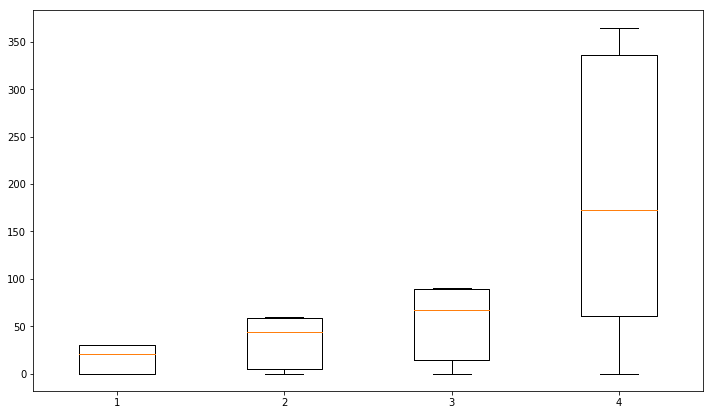

In [8]:
fig= plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.boxplot([df.availability_30,df.availability_60,df.availability_90,df.availability_365])
#ax.set_xlabel(['availability_30','availability_60','availability_90','availability_365'])
plt.show()

Convert price, percentages ro numeric type and impute missing values

In [9]:
df['first_review']=pd.to_datetime(df['first_review'])
df['last_review']=pd.to_datetime(df['last_review'])
fill_mean = lambda col: col.fillna("$0") 
df["security_deposit"] = df[["security_deposit"]].apply(fill_mean, axis=0)
df["cleaning_fee"] = df[["cleaning_fee"]].apply(fill_mean, axis=0)
df["extra_people"] = df[["extra_people"]].apply(fill_mean, axis=0)

In [10]:
df['host_response_rate']=df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
df['host_acceptance_rate']=df['host_acceptance_rate'].str.replace(r'%', r'.0').astype('float') / 100.0

In [11]:
locale.setlocale(locale.LC_ALL,'')
df.security_deposit=df.security_deposit.map(lambda x: locale.atof(x.strip('$'))).astype(int)
df.price=df.price.map(lambda x: locale.atof(x.strip('$'))).astype(int)
df.cleaning_fee=df.cleaning_fee.map(lambda x: locale.atof(x.strip('$'))).astype(int)
df.extra_people=df.extra_people.map(lambda x: locale.atof(x.strip('$'))).astype(int)

Remove Outliers

In [13]:
df=df[df.price<=1000]
df.shape

(24056, 81)

Two-sample comparisons

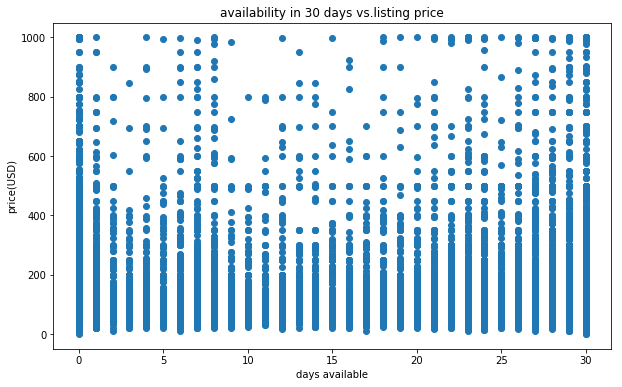

In [14]:
#plt.scatter(df['availability_30'],df['number_of_reviews_ltm'])
fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(df['availability_30'],df['price'])
ax.set_title("availability in 30 days vs.listing price")
ax.set_xlabel("days available")
ax.set_ylabel("price(USD)")

plt.show()

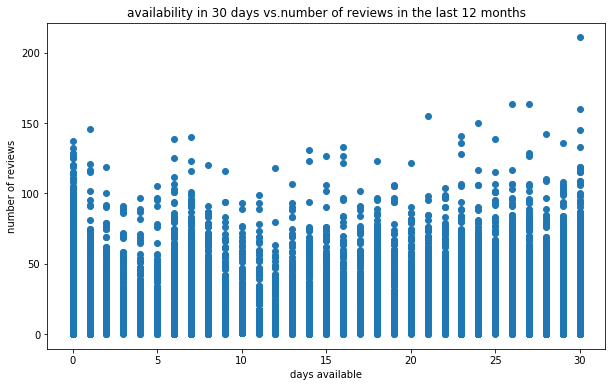

In [16]:
#plt.scatter(df['availability_30'],df['number_of_reviews_ltm'])
fig= plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(df['availability_30'],df['number_of_reviews_ltm'])
ax.set_title("availability in 30 days vs.number of reviews in the last 12 months")
ax.set_xlabel("days available")
ax.set_ylabel("number of reviews")

plt.show()

days
0.0    17.155653
1.0    17.698454
Name: number_of_reviews_ltm, dtype: float64


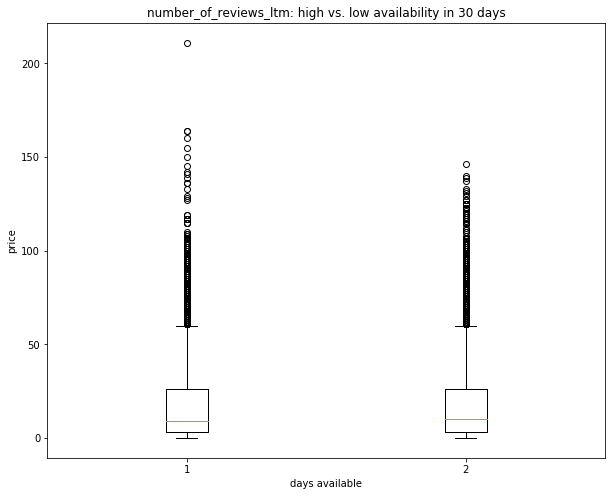

In [129]:
print(df.groupby(['days']).mean()['number_of_reviews_ltm'].dropna())

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.boxplot([df[df.days==0]['number_of_reviews_ltm'].dropna(),df[df.days==1]['number_of_reviews_ltm'].dropna()])
ax.set_title("number_of_reviews_ltm: high vs. low availability in 30 days")
ax.set_xlabel("days available")
ax.set_ylabel("price")

plt.show()

days
0.0    0.893996
1.0    0.908460
Name: host_acceptance_rate, dtype: float64


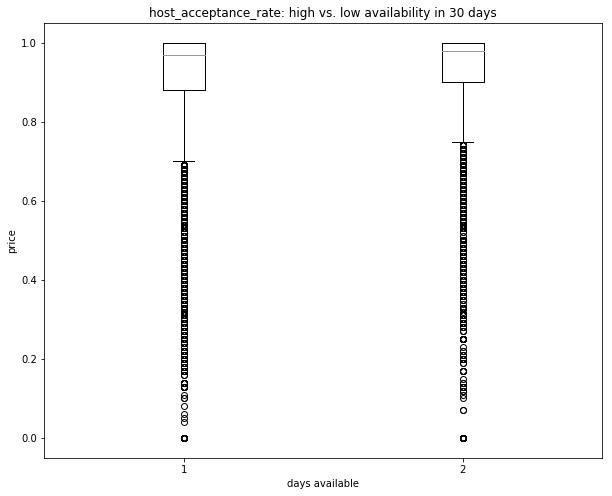

In [130]:
print(df.groupby(['days']).mean()['host_acceptance_rate'].dropna())

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.boxplot([df[df.days==0]['host_acceptance_rate'].dropna(),df[df.days==1]['host_acceptance_rate'].dropna()])
ax.set_title("host_acceptance_rate: high vs. low availability in 30 days")
ax.set_xlabel("days available")
ax.set_ylabel("price")

plt.show()

days
0.0    151.510049
1.0    143.425157
Name: price, dtype: float64


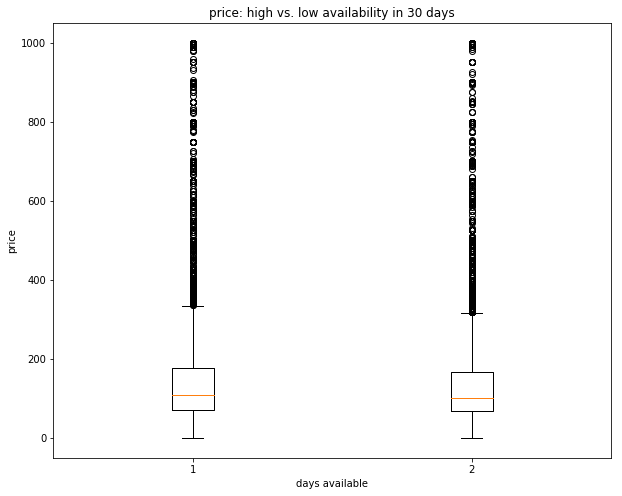

In [131]:
print(df.groupby(['days']).mean()['price'].dropna())

fig= plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.boxplot([df[df.days==0]['price'].dropna(),df[df.days==1]['price'].dropna()])
ax.set_title("price: high vs. low availability in 30 days")
ax.set_xlabel("days available")
ax.set_ylabel("price")

plt.show()

In [35]:
df.groupby(['days']).mean()['host_response_rate'].sort_values(ascending=False).dropna()

days
1.0    0.960476
0.0    0.945897
Name: host_response_rate, dtype: float64

In [36]:
df.groupby(['days']).mean()['review_scores_rating'].sort_values(ascending=False).dropna()

days
1.0    94.914730
0.0    93.647073
Name: review_scores_rating, dtype: float64

In [48]:
df.groupby(['host_is_superhost']).mean()['days'].sort_values(ascending=False).dropna()

host_is_superhost
t    0.531668
f    0.470656
Name: days, dtype: float64

In [52]:
df.groupby(['room_type']).mean()['days'].sort_values(ascending=False).dropna()

room_type
Entire home/apt    0.516742
Private room       0.479786
Hotel room         0.352941
Shared room        0.230061
Name: days, dtype: float64

In [17]:
print(stats.ttest_ind(df[df.room_type=='Entire home/apt']['days'].dropna(),df[df.room_type=='Private room']['days'].dropna()))
print(stats.ttest_ind(df[df.days==1]['accommodates'].dropna(),df[df.days==0]['accommodates'].dropna()))
print(stats.ttest_ind(df[df.days==1]['price'],df[df.days==0]['price']))

print(stats.ttest_ind(df[df.days==1]['host_acceptance_rate'].dropna(),df[df.days==0]['host_acceptance_rate'].dropna()))
print(stats.ttest_ind(df[df.days==1]['host_response_rate'].dropna(),df[df.days==0]['host_response_rate'].dropna()))
print(stats.ttest_ind(df[df.host_is_superhost=='t']['days'].dropna(),df[df.host_is_superhost=='f']['days'].dropna()))

print(stats.ttest_ind(df[df.days==1]['number_of_reviews_ltm'].dropna(),df[df.days==0]['number_of_reviews_ltm'].dropna()))
print(stats.ttest_ind(df[df.days==1]['reviews_per_month'].dropna(),df[df.days==0]['reviews_per_month'].dropna()))

Ttest_indResult(statistic=5.378750371906785, pvalue=7.572854990671971e-08)
Ttest_indResult(statistic=-2.8023140875979506, pvalue=0.005077801342555532)
Ttest_indResult(statistic=-4.139761010374314, pvalue=3.4885195610043844e-05)
Ttest_indResult(statistic=6.713759463012128, pvalue=1.9397157812946656e-11)
Ttest_indResult(statistic=7.330986705171544, pvalue=2.3667918610423353e-13)
Ttest_indResult(statistic=11.410647863277553, pvalue=4.421593025234187e-30)
Ttest_indResult(statistic=3.77250371369404, pvalue=0.00016200484800762434)
Ttest_indResult(statistic=4.231241553335714, pvalue=2.3326516129862234e-05)


### Model Data

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc

Select features to use

In [14]:
features = ['host_response_time', 
    #'host_response_rate', 
    'host_acceptance_rate',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
        'neighbourhood_cleansed','is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
         'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews_ltm', 
    #'review_scores_rating', 
    'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification','reviews_per_month','host_is_superhost',
          'price','days'
    #, 'availability_30'
            ]

df1=df.loc[:, features]

In [15]:
df1.shape

(24056, 37)

Impute Nan and encode categorical variables

In [16]:
#fill_mean = lambda col: col.fillna("f") 
for i in df1.select_dtypes(include=['object']).columns:
    if 'f' in set(df1[i]):
        df1[i] = df1[i].fillna("f")
    else:
        df1[i] = df1[i].fillna("other")
df1=df1.dropna()

In [17]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, 
                                                                 dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df
df1=create_dummy_df(df1, df1.select_dtypes(include=['object']), dummy_na=False)

In [18]:
X=df1.loc[:,df1.columns!='days'].values
y = np.ravel(df1.loc[:,['days']].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

K-nearest neighbors

In [105]:
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred1 = classifier.predict(X_test)
accuracy=accuracy_score(y_test,y_pred1)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 57.74 %.


In [105]:
classifier = KNeighborsClassifier(n_neighbors = 100, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 56.95 %.


In [106]:
classifier = KNeighborsClassifier(n_neighbors = 1000, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 56.8 %.


Support Vector Machine

In [106]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

y_pred2 = classifier.predict(X_test)

C:\Users\xyzou\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [110]:
accuracy=accuracy_score(y_test,y_pred2)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 60.99 %.


Decision Tree

In [107]:
dtree = tree.DecisionTreeClassifier(random_state=0)
    #rclass_weight="balanced",min_weight_fraction_leaf=0.01,)
dtree = dtree.fit(X_train,y_train)

y_pred3 =dtree.predict(X_test)

In [23]:
accuracy=accuracy_score(y_test,y_pred3)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 57.16 %.


Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [21]:
y_pred = rf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 64.27 %.


In [69]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(df1.loc[:,df1.columns!='days'].columns, 
                                                                                      importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[1:35]
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: number_of_reviews_ltm Importance: 0.06
Variable: price                Importance: 0.06
Variable: cleaning_fee         Importance: 0.05
Variable: host_acceptance_rate Importance: 0.04
Variable: host_listings_count  Importance: 0.04
Variable: security_deposit     Importance: 0.04
Variable: extra_people         Importance: 0.04
Variable: maximum_nights       Importance: 0.04
Variable: accommodates         Importance: 0.03
Variable: beds                 Importance: 0.03
Variable: minimum_nights       Importance: 0.03
Variable: bathrooms            Importance: 0.02
Variable: bedrooms             Importance: 0.02
Variable: guests_included      Importance: 0.02
Variable: review_scores_cleanliness Importance: 0.02
Variable: review_scores_value  Importance: 0.02
Variable: host_response_time_other Importance: 0.02
Variable: review_scores_accuracy Importance: 0.01
Variable: review_scores_checkin Importance: 0.01
Variable: review_scores_communication Importance: 0.01
Variable: review_sco

### Plot the result

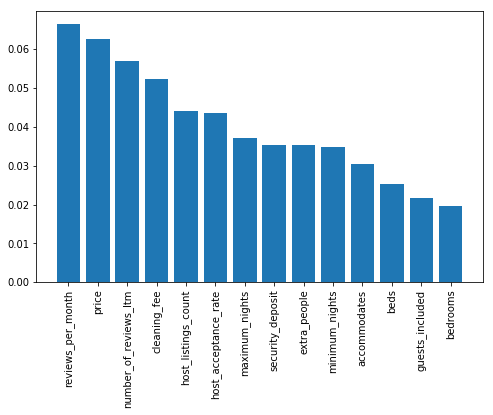

In [25]:
f=pd.DataFrame([df1.loc[:,df1.columns!='days'].columns,importances])
f=np.transpose(f)
f=f.sort_values(f.columns[1],ascending=False).iloc[0:14]

fig= plt.figure(figsize=(8,5))
plt.bar(f[0],f[1])
plt.xticks(rotation=90)
plt.show()

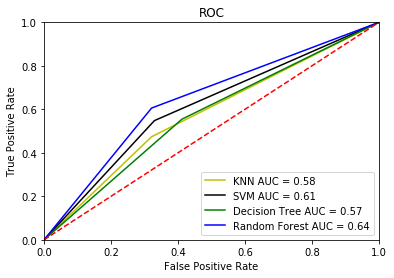

In [119]:
fpr, tpr, _ = roc_curve(y_test, y_pred)  
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)  
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)  
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)  

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.title('ROC')
plt.plot(fpr1, tpr1, 'y', label='KNN AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'black', label='SVM AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'g', label='Decision Tree AUC = %0.2f' % roc_auc3)
plt.plot(fpr, tpr, 'b', label='Random Forest AUC = %0.2f' % roc_auc)


plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Check the Splits

In [79]:
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print (node)

In [ ]:
get_lineage(rf.estimators_[0], X_test[:,12])